In [1]:
# %matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import glob
import warnings
from IPython.display import display

warnings.filterwarnings('ignore')
mpl.rcParams['savefig.dpi'] = 128
mpl.rcParams['figure.dpi'] = 128
# Plot size to 14" x 7"
mpl.rc('figure', figsize = (14, 7))
# Font size to 14
mpl.rc('font', size = 14)
# Do not display top and right frame lines
mpl.rc('axes.spines', top = False, right = False)
# Remove grid lines
mpl.rc('axes', grid = False)
# Set backgound color to white
mpl.rc('axes', facecolor = 'white')

In [2]:
# read whole year data
allFiles = glob.glob("2014-2017/*/*.csv")
df = pd.DataFrame()
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0,encoding="utf-8")
    list_.append(df)
df = pd.concat(list_)

df.shape

(179179, 49)

In [3]:
df.drop_duplicates(inplace=True)
df.shape

(167472, 49)

In [4]:
def transform_cols(df):
    df.columns = map(str.lower, df.columns)
    df.columns = df.columns.str.replace('_', ' ')
    return df

In [5]:
df = transform_cols(df)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names]

In [7]:
selected_features = ['classification','enquired',
                     'loan amount','loan reason','property use']
# selected_features = ['marketing code','enquired',
#                      'loan amount','loan reason','property use']
# selected_features = ['classification','enquired']
# selected_features = ['marketing code','classification','enquired',
#                      'loan amount','loan reason','property use']

target = 'enquiry status';
whole_set = selected_features + [target]

df = df[whole_set]

In [8]:
df = df[~df[target].isin(['In Progress','Just Received','On Hold'])]
df.shape

(162873, 6)

In [9]:
# Inspired from stackoverflow.com/questions/25239958
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent = pd.Series([X[c].value_counts().index[0] for c in X],
                                       index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent)

In [10]:
def clearnLoanAmount(df): 
    invalid_columns= ['500001-$1000000',
                  '300001-$500000',
                  '0-$300000',
                  '250000 - 300000',
                  '250000-350000',
                  '2600 monthly',
                  'not_sure',
                  '1000,001+',
                  '9999-',
                  'I50000',
                  '1.5 M',
                  '1000001+',
                  '9999-',
                  '80-90k']
    if 'loan amount' in df.columns: 
#         df['loan amount'].fillna(0,inplace=True)
        df['loan amount'] =  df['loan amount'].fillna(df['loan amount'].value_counts().index[0])
        # convert to string to do replacement
        df['loan amount'] = df['loan amount'].astype("str")
        df['loan amount'] = df['loan amount'].str.replace(",","")
        df = df[~df['loan amount'].isin(invalid_columns)]
    return df

In [11]:
df = clearnLoanAmount(df)

In [12]:
df.shape

(162111, 6)

In [13]:
df['loan reason'].fillna('Other Loan Reason',inplace=True)

In [14]:
df['loan reason'].value_counts()

First HomeBuyer                                           64061
Buying Again                                              53172
Other Loan Reason                                         20267
Refinance                                                 15469
Buying Again,Refinance                                     4799
Refinance With Cash Out                                    3114
Refinance,Refinance With Cash Out                           410
Buying Again,Refinance With Cash Out                        349
First HomeBuyer,Refinance                                   199
First HomeBuyer,Buying Again                                163
Buying Again,Refinance,Refinance With Cash Out               42
Loan Topup                                                   15
Refinance,Other Loan Reason                                  10
First HomeBuyer,Buying Again,Refinance                        9
Buying Again,Refinance,Other Loan Reason                      8
Buying Again,Other Loan Reason          

In [15]:
# df.loc[df['loan reason'].str.contains('First HomeBuyer'),'loan reason'] = 'First HomeBuyer'
# df.loc[df['loan reason'].str.contains('Buying Again'),'loan reason'] = 'Buying Again'
# df.loc[df['loan reason'].str.contains('Refinance'),'loan reason'] = 'Refinance'

df['loan reason'] = df['loan reason'].apply(lambda x: 'First HomeBuyer' if 'First HomeBuyer' in x else x)
df['loan reason'] = df['loan reason'].apply(lambda x: 'Buying Again' if 'Buying Again' in x else x)
df['loan reason'] = df['loan reason'].apply(lambda x: 'Refinance' if 'Refinance' in x else x)

In [16]:
df['loan reason'].value_counts()

First HomeBuyer      64448
Buying Again         58378
Other Loan Reason    20267
Refinance            19003
Loan Topup              15
Name: loan reason, dtype: int64

In [17]:
df['property use'].fillna('Other',inplace=True)

In [18]:
df['property use'].value_counts()

Residence                     100974
Other                          38442
Investment                     17138
Residence,Investment            5401
Residence,Other                  111
Residence,Investment,Other        25
Investment,Other                  20
Name: property use, dtype: int64

In [19]:
df['property use'] = df['property use'].apply(lambda x: 'Residence' if 'Residence' in x else x)
df['property use'] = df['property use'].apply(lambda x: 'Investment' if 'Investment' in x else x)

In [20]:
df['property use'].value_counts()

Residence     106511
Other          38442
Investment     17158
Name: property use, dtype: int64

In [21]:
df['classification'].fillna('None',inplace=True)

In [22]:
df['classification'].value_counts()

Domain                         34545
Alternative Media              19131
Google AdWords                 14654
Coregistration                 13929
Omnilead                       12845
REA                            11164
Home Sales                      8089
All Homes                       7678
First Home Buyers               5516
Domain Campaigns                5116
Direct                          4991
Domain Internal CBA Program     3620
Affiliate                       3177
Finder                          2602
Email eChoice Database          2314
Domain Campaigns CPA            1975
Domain Competitions             1791
Phone                           1532
Folio                           1173
Dynamic Home Loans              1034
Refinancing AdWords              893
Referrer                         579
Social Media                     548
Partners                         455
Home Hound                       403
Portal Campaigns                 371
External Email                   282
R

In [23]:
for _ in df.columns:
    print("The number of null values in: {} == {}".format(_, df[_].isnull().sum()))

The number of null values in: classification == 0
The number of null values in: enquired == 0
The number of null values in: loan amount == 0
The number of null values in: loan reason == 0
The number of null values in: property use == 0
The number of null values in: enquiry status == 0


In [24]:
df.dropna(axis=0, how='any', inplace=True)
df.shape

(162111, 6)

In [25]:
df.describe()

,classification,enquired,loan amount,loan reason,property use,enquiry status
count,162111,162111,162111,162111,162111,162111
unique,47,134222,9156,5,3,2
top,Domain,25-Feb-2016 00:35:26,0,First HomeBuyer,Residence,Rejected
freq,34545,9,35804,64448,106511,136266


In [26]:
for _ in df.columns:
    print("The number of null values in:{} == {}".format(_, df[_].isnull().sum()))

The number of null values in:classification == 0
The number of null values in:enquired == 0
The number of null values in:loan amount == 0
The number of null values in:loan reason == 0
The number of null values in:property use == 0
The number of null values in:enquiry status == 0


In [27]:
drop_values = ['QLD','victoria',"270-1176","VIC","2575b","6110r","2150s"]
if 'post code' in df.columns: 
    df = df[~df['post code'].isin(drop_values)]

In [28]:
df.to_csv("2007-2017_origin.csv",index=False)

In [29]:
def transform(df): 
    if 'loan amount' in df.columns: 
        df['loan amount'] = df['loan amount'].astype('float')
        
    if 'enquired' in df.columns: 
        df['enquired'] = pd.DatetimeIndex(df['enquired'])
        df['year'] = df['enquired'].dt.year
        df['month'] = df['enquired'].dt.month
        df['day'] = df['enquired'].dt.day
        df['hour'] = df['enquired'].dt.hour
        df['weekday'] = df['enquired'].dt.dayofweek
    
    if 'post code' in df.columns: 
        df['post code'] = df['post code'].astype('int')
    
    if 'enquired'in df.columns:
        df.drop(['enquired'], axis = 1, inplace = True)
        
    
    df.apply(lambda x: x.astype(str).str.lower())

In [30]:
transform(df)

In [31]:
if 'year' in df.columns:
    df = df[~(df['year'] < 2014)]
    display(df[(df['year'] < 2014)])

,classification,loan amount,loan reason,property use,enquiry status,year,month,day,hour,weekday


In [32]:
df.reset_index(drop=True,inplace=True)

In [33]:
test = df[df['enquiry status'] == 'Rejected']
test.shape

(133932, 10)

In [34]:
test = df[df['enquiry status'] == 'Accepted']
test.shape

(25277, 10)

In [35]:
test['year'].value_counts()

2015    7610
2014    6841
2016    6374
2017    4452
Name: year, dtype: int64

In [36]:
df.dtypes

classification     object
loan amount       float64
loan reason        object
property use       object
enquiry status     object
year                int64
month               int64
day                 int64
hour                int64
weekday             int64
dtype: object

In [37]:
df['classification'].value_counts()

Domain                         33796
Alternative Media              19131
Google AdWords                 13962
Coregistration                 13179
Omnilead                       12845
REA                            10941
Home Sales                      8089
All Homes                       7678
First Home Buyers               5516
Domain Campaigns                5114
Direct                          4696
Domain Internal CBA Program     3620
Affiliate                       3140
Finder                          2595
Email eChoice Database          2287
Domain Campaigns CPA            1975
Domain Competitions             1791
Phone                           1493
Folio                           1173
Dynamic Home Loans              1034
Refinancing AdWords              893
Referrer                         579
Social Media                     544
Partners                         436
Home Hound                       403
Portal Campaigns                 350
Retention                        264
E

In [38]:
# df = df[~df['marketing code'].isin(rows_to_drop)]
# df.shape
# df.drop_duplicates()
# duplicates = df[df.duplicated()]
# duplicates[duplicates['enquiry status'] == 'Accepted']

In [39]:
hist = test.groupby(['year']).size().reset_index(name="counts")

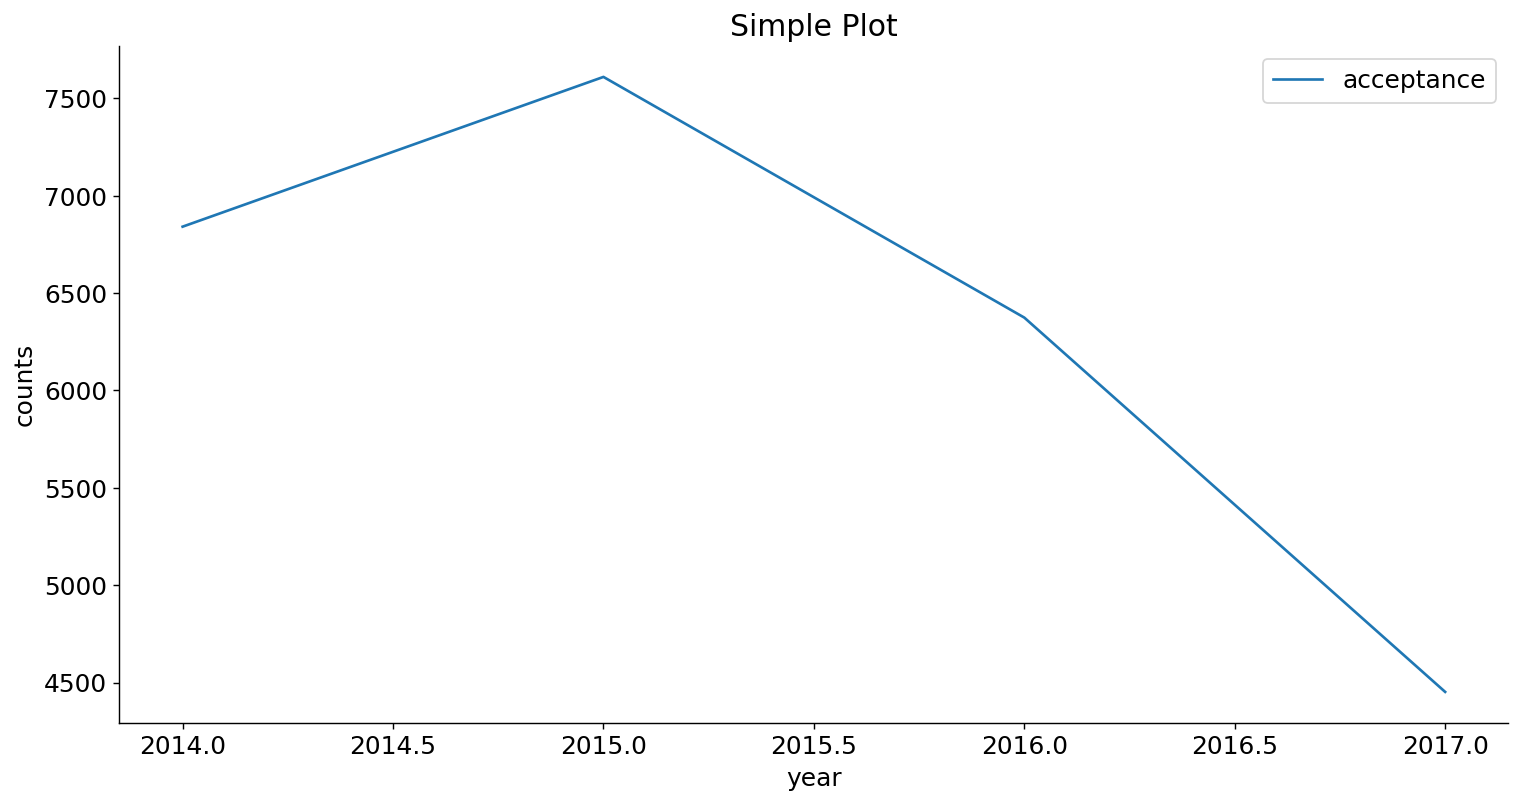

In [40]:
fig = plt.figure()
plt.plot(hist["year"], hist["counts"], label='acceptance')
plt.xlabel('year')
plt.ylabel('counts')
plt.title("Simple Plot")
plt.legend()
plt.show()

In [41]:
df.shape

(159209, 10)

In [42]:
data_frame = df.drop('year', axis = 1) 
data_frame['loan amount'] = data_frame['loan amount'].astype(int)

In [43]:
# df.to_csv("2014-2017.csv",index=False)

In [44]:
data_frame.to_csv("2014-2017.csv",index=False)

In [45]:
df[df.duplicated]

,classification,loan amount,loan reason,property use,enquiry status,year,month,day,hour,weekday
3,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,2,2
6,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,5,2
14,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,9,2
15,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,9,2
16,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,9,2
18,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,10,2
20,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,10,2
21,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,10,2
27,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,11,2
29,Coregistration,0.0,First HomeBuyer,Other,Rejected,2014,1,1,11,2


Because marketing code is variable that has changed in so many years, so it has much less impact on the result compare to other features